In [1]:
#Imports
import numpy as np 
from NNetwork import NNetwork as nn ## pip install nnetwork (version >= 0.2.0)
import networkx as nx
#import utils.NNetwork as nn
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics, model_selection
from tqdm import trange
from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from scipy import stats
from scipy.stats import wilcoxon, median_test, kstest

# Subgraphs induced on uniformly random k-paths

In [2]:
#ntwk_list = ['Caltech36', 'UCLA26', 'true_edgelist_for_ER_5000_mean_degree_50', 'true_edgelist_for_BA_5000_m_50', 'true_edgelist_for_SW_5000_k_50_p_0.1', 'SBM1']
ntwk = 'Caltech36'
sampling_alg = 'pivot'
save_folder = 'Network_dictionary/test1/'

path = "Data/Facebook/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges())//2) # .get_edges() returns ordered pair of edges

num nodes in G 769
num edges in G 16656


In [6]:
X, embs = G.get_patches(k=7, sample_size=100, sampling_alg='pivot') #MCMC motif sampling
                    #sampling_alg='glauber', 'pivot' or  'idla' or 'pivot_inj'

In [7]:
embs

[array(['725', '116', '552', '525', '118', '499', '571'], dtype='<U32'),
 array(['725', '560', '720', '587', '525', '280', '223'], dtype='<U32'),
 array(['725', '116', '558', '355', '161', '420', '142'], dtype='<U32'),
 array(['725', '649', '720', '219', '464', '605', '570'], dtype='<U32'),
 array(['725', '709', '582', '132', '745', '226', '390'], dtype='<U32'),
 array(['725', '709', '380', '412', '393', '328', '157'], dtype='<U32'),
 array(['725', '158', '343', '330', '420', '418', '700'], dtype='<U32'),
 array(['725', '116', '532', '767', '208', '85', '342'], dtype='<U32'),
 array(['725', '116', '151', '484', '142', '283', '2'], dtype='<U32'),
 array(['725', '158', '649', '265', '477', '5', '249'], dtype='<U32'),
 array(['725', '649', '590', '155', '765', '263', '544'], dtype='<U32'),
 array(['725', '560', '131', '117', '570', '462', '479'], dtype='<U32'),
 array(['649', '112', '330', '162', '202', '291', '556'], dtype='<U32'),
 array(['492', '615', '574', '619', '615', '498', '198']

In [8]:
X.shape

(49, 100)

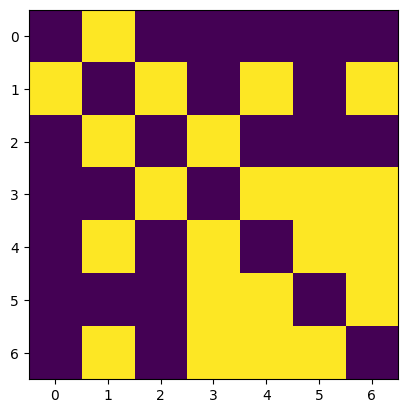

In [9]:
plt.imshow(X[:,4].reshape(7,7))

In [10]:
def motif_sample_display_list(list_graphs, k=20, sample_size=100,
                              subtitle = None,
                              skip_folded_hom=True, grid_shape=[5,3],
                              fig_size=[10,3],
                              save_path=None):
    # list of graphs in NNetwork format
    X_list = []
    embs_list = []
    for G in list_graphs:
        X, embs = G.get_patches(k=k, sample_size=sample_size, skip_folded_hom=skip_folded_hom)
        X_list.append(X)
        embs_list.append(embs)
       


    fig = plt.figure(figsize=fig_size, constrained_layout=False)
    # make outer gridspec

    outer_grid = gridspec.GridSpec(nrows=1, ncols=len(list_graphs), wspace=0.2, hspace=0.2)

    for i in np.arange(len(list_graphs)):
        if subtitle is not None:
            ax = plt.Subplot(fig, outer_grid[i])
            ax.set_title(subtitle[i], fontsize=15)
            ax.axis('off')
            fig.add_subplot(ax)

        Ndict_wspace = 0.05
        Ndict_hspace = 0.05

        rows = grid_shape[0]
        cols = grid_shape[1]

        inner_grid = outer_grid[i].subgridspec(rows, cols,
                                               wspace=Ndict_wspace, hspace=Ndict_hspace)

        idx = np.arange(X.shape[1])
        X = X_list[i]
        embs = embs_list[i]

        for j in range(rows * cols):
            emb = embs[idx[j]]

            a = j // cols
            b = j % cols

            # get rid of duplicate nodes
            A = X[:,idx[j]]
            A = X[:,idx[j]].reshape(int(np.sqrt(X.shape[0])), -1)
            H = nn.NNetwork()
            H.read_adj(A, embs[idx[j]])
            A_sub = H.get_adjacency_matrix()

            # read in as a nx graph for plotting

            G1 = nx.Graph()
            for w in np.arange(len(emb)):
                G1.add_node(emb[w])

            for p in np.arange(len(emb)):
                for q in np.arange(len(emb)):
                    u = emb[p]
                    v = emb[q]

                    if H.has_edge(u,v):
                        if np.abs(p-q) == 1:
                            G1.add_edge(u,v, color='r', weight=2)
                        else:
                            G1.add_edge(u,v, color='b', weight=0.5)



            ax = fig.add_subplot(inner_grid[a, b])
            pos = nx.spring_layout(G1)
            edges = G1.edges()
            colors = [G1[u][v]['color'] for u,v in edges]

            weights = [1*G1[u][v]['weight'] for u,v in edges]
            nx.draw(G1, with_labels=False, node_size=10, ax=ax,
                    width=weights, edge_color=colors, label='Graph')

            ax.set_xticks([])
            ax.set_yticks([])

        #plt.suptitle(title, fontsize=15)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        if save_path is not None:
            fig.savefig(save_path, bbox_inches='tight')



num of subgraphs induced on k-paths: 25


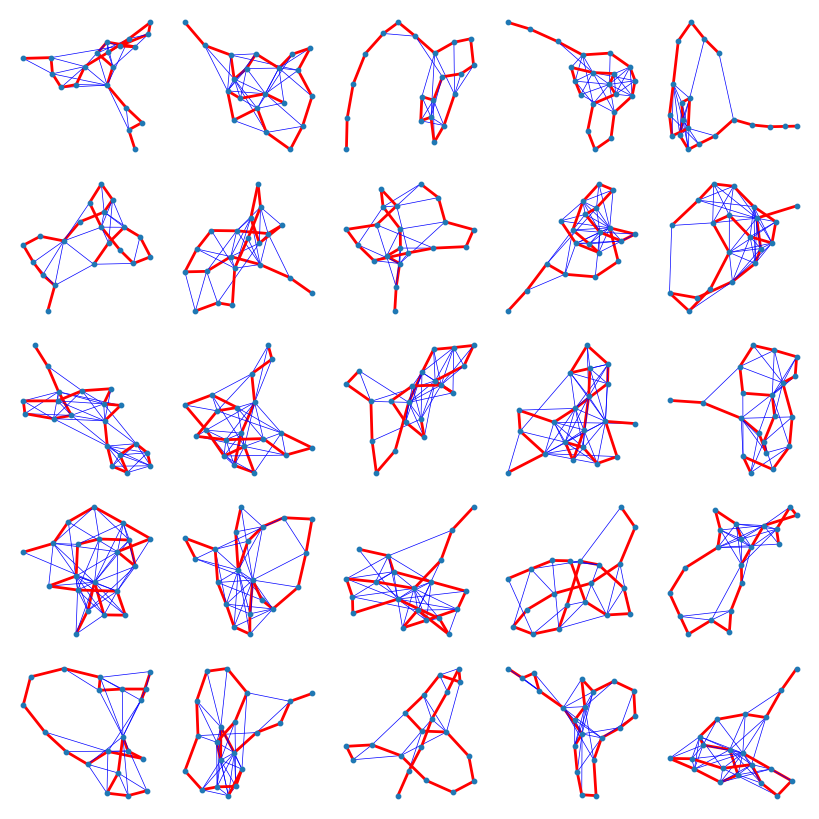

In [11]:
motif_sample_display_list(list_graphs=[G], k=20, 
                          subtitle=None,
                          sample_size=25, 
                          grid_shape=[5,5],
                          save_path = 'subgraphs_ex.pdf',
                          fig_size = [10,10])

# Weighted network 

In [12]:
#path = "Data/"+ "bio-CE-HT.txt"
path = "Data/"+ "bio-SC-CC.txt"

edgelist = list(np.genfromtxt(path, delimiter="", dtype=str)) 
print("edgelist[0] =", edgelist[0])
wts = [float(edgelist[i][-1]) for i in np.arange(len(edgelist))]
max_wt = max(wts)

# Add in all edges in the edgelist to G
G = nn.NNetwork()
for e in edgelist:
    #print("float(e[2])", float(e[2]))
    G.add_edge(edge=[e[0], e[1]], weight=float(e[2])/max_wt)  

edgelist[0] = ['0' '1' '1.7047197354202']


In [13]:
G.get_wtd_edgelist()

[['0', '5', 0.4010436529220999],
 ['0', '1', 0.49921310710682826],
 ['0', '3', 0.3822572027611465],
 ['0', '4', 0.4511017934833089],
 ['0', '2', 0.38196800623835103],
 ['1', '946', 0.3911227687822715],
 ['1', '341', 0.4075860641283175],
 ['1', '910', 0.9861126359863749],
 ['1', '251', 0.9809690863351144],
 ['1', '790', 0.42015709674624097],
 ['1', '272', 0.40715089156316636],
 ['1', '866', 0.7285800414824789],
 ['1', '39', 0.40438826271942063],
 ['1', '575', 0.7206619948688161],
 ['1', '914', 0.4150087108269162],
 ['1', '942', 0.4257321729134377],
 ['1', '398', 0.38600051071272623],
 ['1', '1074', 0.4170401933569657],
 ['1', '620', 0.4331081534953543],
 ['1', '722', 0.514085367885999],
 ['1', '413', 0.7237358082243761],
 ['1', '28', 0.39056888855907773],
 ['1', '841', 0.3988359799614199],
 ['1', '181', 0.4160379888868941],
 ['1', '49', 0.40008285122455745],
 ['1', '1084', 0.39730078261012236],
 ['1', '1099', 0.6707708872995808],
 ['1', '653', 0.3914740456325646],
 ['1', '1055', 0.43780

In [14]:
k=5
X, embs = G.get_patches(k=k, 
                        sample_size=200, 
                        skip_folded_hom = False, # if true, reject non-injective homomoprphisms
                        sampling_alg='pivot') #MCMC motif sampling
                    #sampling_alg='glauber', 'pivot' or  'idla' or 'pivot_inj'

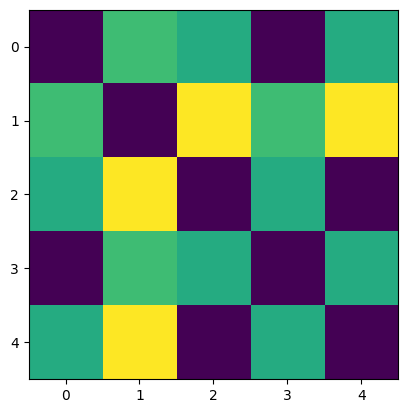

In [15]:
plt.imshow(X[:,10].reshape(k,k))

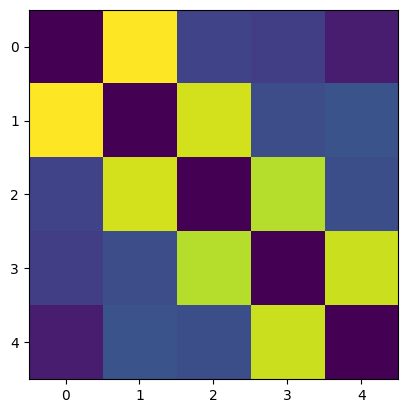

In [16]:
MACC = np.mean(X, axis=-1).reshape(k,k)
plt.imshow(MACC)

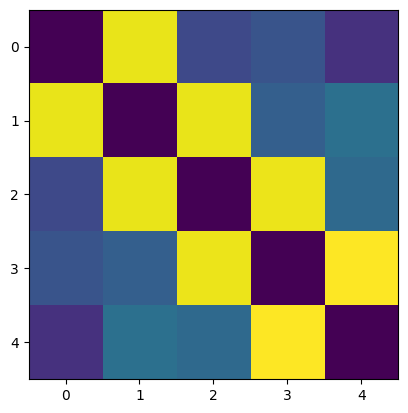

In [17]:
MACC = G.MACC(k=k, 
                sample_size=200, 
                skip_folded_hom = False, # if true, reject non-injective homomoprphisms
                sampling_alg='pivot')
plt.imshow(MACC)

In [18]:
profile_mx = G.chdp_mx(k = 5, 
                        sample_size=500,
                        skip_folded_hom=False,
                        sampling_alg='pivot',
                        filt_lvl=500)

100%|███████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


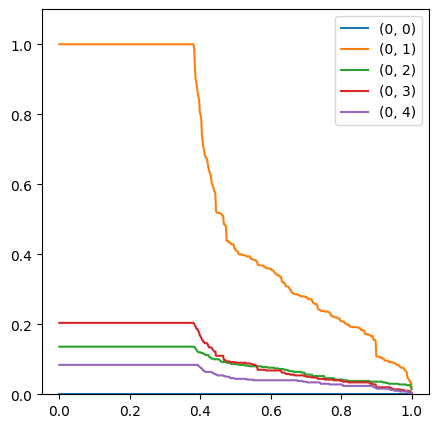

In [19]:
k = profile_mx.shape[0]
filt_lvl = profile_mx.shape[-1]

fig = plt.figure(figsize=[5,5], constrained_layout=False)
ax = fig.add_subplot()
for i in np.arange(k):
    ax.plot(np.linspace(0,1,profile_mx.shape[-1]), profile_mx[0, i], label=(0,i))
ax.set_ylim([0, 1.1]);
ax.legend()

# Randomly edge-weighted SBM

In [20]:
sizes = [50, 50, 50]
probs = [[0.6, 0.2, 0.3], [0.2, 0.8, 0.1], [0.3, 0.1, 0.7]]
G1 = nx.stochastic_block_model(sizes, probs, seed=0)
#nx.draw_networkx(G1)
print('num nodes in G', len(G1.nodes))
print('num edges in G', len(G1.edges))

num nodes in G 150
num edges in G 4093


In [21]:
G2 = nn.NNetwork()
for e in G1.edges():
    G2.add_edge(edge=[e[0],e[1]], weight=np.random.rand())

In [22]:
k=7
X, embs = G2.get_patches(k=k, 
                        sample_size=1000, 
                        skip_folded_hom = True, # if true, reject non-injective homomoprphisms
                        sampling_alg='pivot') #MCMC motif sampling
                    #sampling_alg='glauber', 'pivot' or  'idla' or 'pivot_inj'

num of subgraphs induced on k-paths: 1000


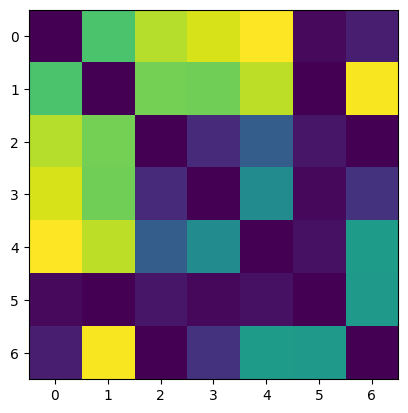

In [23]:
plt.imshow(X[:,0].reshape(k,k))

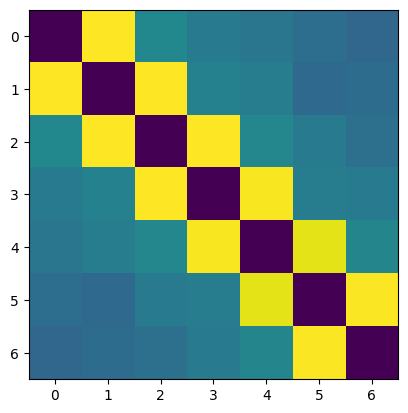

In [24]:
MACC = np.mean(X, axis=-1).reshape(k,k)
plt.imshow(np.mean(X, axis=-1).reshape(k,k))

In [25]:
profile_mx = G2.chdp_mx(k = 7, 
                        sample_size=500,
                        skip_folded_hom=False,
                        sampling_alg='pivot',
                        filt_lvl=500)

100%|███████████████████████████████████████████████| 7/7 [00:15<00:00,  2.17s/it]


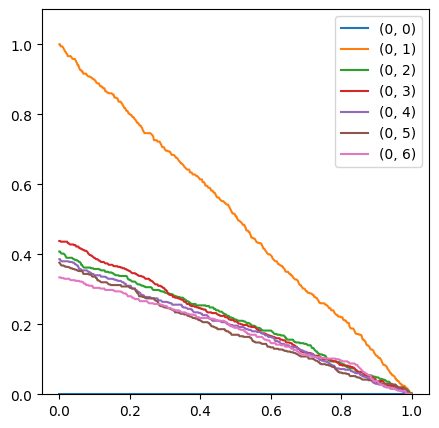

In [26]:
k = profile_mx.shape[0]
filt_lvl = profile_mx.shape[-1]

fig = plt.figure(figsize=[5,5], constrained_layout=False)
ax = fig.add_subplot()
for i in np.arange(k):
    ax.plot(np.linspace(0,1,profile_mx.shape[-1]), profile_mx[0, i], label=(0,i))
ax.set_ylim([0, 1.1]);
ax.legend();